## Step 1 - Download Network from [STRING](https://string-db.org/cgi/input?sessionId=bIvRxxC0rWvS&input_page_show_search=on)

In string upload dop_geneids.txt to string (make sure to click on multiple proteins)

Select Homo Sapiens in Organism and click Search

Quickly double check the mapping is correct before clicking continue

You should now see your full protein-protein interaction network

What we would like to do is to identify clusters of enriched terms in this network

First step is to cluster the network. This can be achieved in STRING by selecting Clusters -> MCL Clustering

Change edge between clsuters to solid line

The next step is to download our clustered network. 

This is achieved by selceting Exports -> '... as tabular text output' 

This file is the full network with edges between every node. It is a '.tsv' format which can work with in Python

## Step 2 - Import Network into Python

In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [192]:
df = pd.read_csv('string_interactions.tsv' , delimiter='\t')

In [197]:
df

,#node1,node2,node1_string_id,node2_string_id,neighborhood_on_chromosome,gene_fusion,phylogenetic_cooccurrence,homology,coexpression,experimentally_determined_interaction,database_annotated,automated_textmining,combined_score
0,ADCY5,GNB3,9606.ENSP00000419361,9606.ENSP00000229264,0.0,0.0,0.0,0.0,0.085,0.070,0.6,0.087,0.647
1,ADCY5,GNB4,9606.ENSP00000419361,9606.ENSP00000232564,0.0,0.0,0.0,0.0,0.062,0.070,0.6,0.164,0.669
2,ADCY5,GNG13,9606.ENSP00000419361,9606.ENSP00000248150,0.0,0.0,0.0,0.0,0.103,0.000,0.6,0.266,0.713
3,ADCY5,GNG11,9606.ENSP00000419361,9606.ENSP00000248564,0.0,0.0,0.0,0.0,0.000,0.000,0.6,0.077,0.615
4,ADCY5,GNGT1,9606.ENSP00000419361,9606.ENSP00000248572,0.0,0.0,0.0,0.0,0.000,0.000,0.6,0.049,0.603
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5267,TH,CREB1,9606.ENSP00000370571,9606.ENSP00000387699,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.676,0.676
5268,TH,SLC18A1,9606.ENSP00000370571,9606.ENSP00000387549,0.0,0.0,0.0,0.0,0.066,0.163,0.0,0.691,0.738
5269,TH,DRD1,9606.ENSP00000370571,9606.ENSP00000377353,0.0,0.0,0.0,0.0,0.064,0.000,0.0,0.771,0.777
5270,TH,PPP2R5D,9606.ENSP00000370571,9606.ENSP00000417963,0.0,0.0,0.0,0.0,0.000,0.000,0.9,0.139,0.910


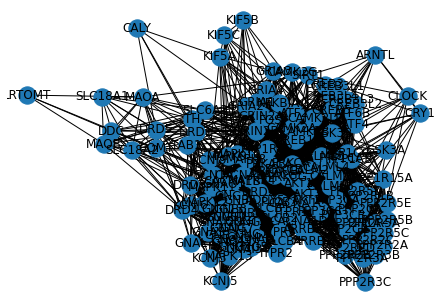

In [202]:
G = nx.Graph() #Create an empty graph

G.add_nodes_from(set(df['#node1']) & set(df['node2'])) #add all nodes. Note we need to cover the scenario 
# where node2 is connected to node1 only

edges = []
for edge1 , edge2  in zip(df['#node1'] , df['node2']) : #add all edge to the network
    edges.append((edge1 , edge2 ))

G.add_edges_from(edges)

nx.draw(G , with_labels = True) #plot the network, notice the similar shape to STRING

In [205]:
print(G.nodes) #note how we keep our gene ids in the node names

['SCN1A', 'PPP2R2B', 'TH', 'PRKCA', 'DDC', 'GSK3B', 'ARRB2', 'PLCB4', 'AKT2', 'PPP2R2D', 'PPP2R3B', 'GRIA2', 'GNAI3', 'CACNA1D', 'PPP3CB', 'KIF5A', 'PPP2CA', 'ADCY5', 'MAPK8', 'KCNJ3', 'PLCB3', 'CALML3', 'CACNA1C', 'NFKBIA', 'PRKCB', 'PPP2R1A', 'CACNA1A', 'PPP2R5A', 'SIRT1', 'ATF6B', 'SLC18A2', 'PRKACA', 'ARNTL', 'SLC6A3', 'GNGT1', 'KCNJ9', 'GNB3', 'CAMK2B', 'MAPK12', 'PPP2R3A', 'ITPR1', 'MAPK14', 'GRIN2B', 'CREB1', 'PRKACB', 'DRD5', 'PRKCG', 'MAPK13', 'DRD4', 'GNG3', 'ITPR2', 'CREB3', 'DRD2', 'AKT3', 'LRTOMT', 'GNAI2', 'GNB4', 'CREB3L1', 'KIF5B', 'GNG2', 'ITPR3', 'COMT', 'CRY1', 'MAPK9', 'KCNJ5', 'PPP2R2A', 'GNB2', 'CREB3L3', 'GNAL', 'PPP1R1B', 'GRIA3', 'GSK3A', 'PPP2R3C', 'GNB1', 'KCNJ6', 'GNG7', 'PPP2R5C', 'MAPK11', 'ATF4', 'PPP2CB', 'PPP2R5D', 'SLC18A1', 'PPP1CC', 'GNAS', 'PPP1CB', 'MAPK10', 'TAB1', 'FOS', 'GRIA1', 'CREB5', 'PPP2R5B', 'CLOCK', 'PPP3CC', 'GRIN2A', 'DRD3', 'GNAQ', 'DRD1', 'PPP2R5E', 'MAOB', 'GNAI1', 'CALM2', 'GNGT2', 'GNAO1', 'CACNA1B', 'CALML4', 'CAMK2G', 'ATF2', 'G

## Step 3 - Impose an ordering on our list of gene ids and perform Enrichment Analysis

### [GSEApy](https://gseapy.readthedocs.io/en/latest/index.html)

GSEApy is a library to perform gene set enrichment analysis (GSEA) in python. There are two methods to perform enrichment analysis - over representation analysis and GSEA. The main difference between the two is that GSEA assumes your input list of genes is ordered by the most representative genes in that list. 

### Enrichment Analysis Measures

In order to perform GSEA we need to impose an ordering on the list of gene ids. We want to order genes such that the genes which are most important to the above network are listed highest. 

Important genes to the network are ones that are central to the network structural i.e. removing these nodes will split the network or cause it to lose its structure. This means they tend to have highest number of connections and located in the centres of clusters.

### Measure 1 - Node Degree

Node degree is simply the number of connections a node has. The higher the number of connections, the more important the node

In [207]:
sorted_list = sorted(G.degree(), key=lambda item: item[1] , reverse=True) #sort the genes (node names) by degree

sorted_genes = []
for item in sorted_list : #extract just the node names from the sorted list
    sorted_genes.append(item[0])
    
enr = gseapy.enrichr(gene_list=sorted_genes, # perform enrichment analysis using gsea
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Dopaminergic synapse,130/132,0.000000e+00,0.000000e+00,0,0,258219.000000,inf,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...
1,KEGG_2021_Human,Circadian entrainment,59/97,3.010973e-108,2.965808e-106,0,0,405.052978,1.002818e+05,CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...
2,KEGG_2021_Human,Amphetamine addiction,52/69,8.768466e-103,5.757959e-101,0,0,731.464210,1.718905e+05,ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...
3,KEGG_2021_Human,Cholinergic synapse,58/113,4.130313e-100,2.034179e-98,0,0,271.305785,6.208566e+04,GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...
4,KEGG_2021_Human,Adrenergic signaling in cardiomyocytes,61/150,1.857583e-97,7.318877e-96,0,0,183.166717,4.079699e+04,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...
5,KEGG_2021_Human,Human cytomegalovirus infection,64/225,1.377437e-90,4.522583e-89,0,0,110.318957,2.282636e+04,ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...
6,KEGG_2021_Human,Relaxin signaling pathway,55/129,9.742298e-89,2.741761e-87,0,0,183.869088,3.726173e+04,ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...
7,KEGG_2021_Human,Retrograde endocannabinoid signaling,55/148,1.330175e-84,3.275556e-83,0,0,146.163978,2.822892e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...
8,KEGG_2021_Human,Serotonergic synapse,50/113,2.520822e-81,5.517800e-80,0,0,184.892624,3.431326e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...
9,KEGG_2021_Human,Glutamatergic synapse,50/114,4.471855e-81,8.809554e-80,0,0,181.994485,3.367109e+04,GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...


### Measure 2 - Closeness Centrality 
This is a measure of how close a node is to the center of the network. The closer a node is to the center the shorter its path to all other nodes and hence its more likely to be representative of the network

In [208]:
sorted_list = sorted(nx.closeness_centrality(G).items(), key=lambda item: item[1] , reverse=True) 
#sort the genes (node names) by proximity to center

sorted_genes = []
for item in sorted_list : #extract just the node names from the sorted list
    sorted_genes.append(item[0])
    
enr = gseapy.enrichr(gene_list=sorted_genes, # perform enrichment analysis using gsea
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Dopaminergic synapse,130/132,0.000000e+00,0.000000e+00,0,0,258219.000000,inf,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...
1,KEGG_2021_Human,Circadian entrainment,59/97,3.010973e-108,2.965808e-106,0,0,405.052978,1.002818e+05,CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...
2,KEGG_2021_Human,Amphetamine addiction,52/69,8.768466e-103,5.757959e-101,0,0,731.464210,1.718905e+05,ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...
3,KEGG_2021_Human,Cholinergic synapse,58/113,4.130313e-100,2.034179e-98,0,0,271.305785,6.208566e+04,GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...
4,KEGG_2021_Human,Adrenergic signaling in cardiomyocytes,61/150,1.857583e-97,7.318877e-96,0,0,183.166717,4.079699e+04,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...
5,KEGG_2021_Human,Human cytomegalovirus infection,64/225,1.377437e-90,4.522583e-89,0,0,110.318957,2.282636e+04,ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...
6,KEGG_2021_Human,Relaxin signaling pathway,55/129,9.742298e-89,2.741761e-87,0,0,183.869088,3.726173e+04,ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...
7,KEGG_2021_Human,Retrograde endocannabinoid signaling,55/148,1.330175e-84,3.275556e-83,0,0,146.163978,2.822892e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...
8,KEGG_2021_Human,Serotonergic synapse,50/113,2.520822e-81,5.517800e-80,0,0,184.892624,3.431326e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...
9,KEGG_2021_Human,Glutamatergic synapse,50/114,4.471855e-81,8.809554e-80,0,0,181.994485,3.367109e+04,GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...


### Measure 3 - Clustering Coefficient
The clustering coefficient is a measure which combines centrality and degree. It measures the number of triangles a node can form ('the friend of my friend is my friend'). If a node has more common friends with other nodes it more likely to representative of the network

In [209]:
sorted_list = sorted(nx.clustering(G).items(), key=lambda item: item[1] , reverse=True)
#sort the genes (node names) by clustering coefficient

sorted_genes = []
for item in sorted_list : #extract just the node names from the sorted list
    sorted_genes.append(item[0])
    
enr = gseapy.enrichr(gene_list=sorted_genes, # perform enrichment analysis using gsea
                 gene_sets=['KEGG_2021_Human'],
                 organism='human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None, # don't write to disk
                )

enr.results.head(10) #return the top 10 hits

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Dopaminergic synapse,130/132,0.000000e+00,0.000000e+00,0,0,258219.000000,inf,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;COMT;...
1,KEGG_2021_Human,Circadian entrainment,59/97,3.010973e-108,2.965808e-106,0,0,405.052978,1.002818e+05,CALML5;CALML6;CALML3;CALML4;GNGT1;GNGT2;PRKACG...
2,KEGG_2021_Human,Amphetamine addiction,52/69,8.768466e-103,5.757959e-101,0,0,731.464210,1.718905e+05,ATF2;CALML5;CALML6;CALML3;CALML4;SLC6A3;PPP1CB...
3,KEGG_2021_Human,Cholinergic synapse,58/113,4.130313e-100,2.034179e-98,0,0,271.305785,6.208566e+04,GNGT1;GNGT2;CREB3L3;CREB3L4;CREB3L1;AKT2;PRKAC...
4,KEGG_2021_Human,Adrenergic signaling in cardiomyocytes,61/150,1.857583e-97,7.318877e-96,0,0,183.166717,4.079699e+04,ATF2;CALML5;CALML6;CALML3;PPP2R2A;CALML4;PPP1C...
5,KEGG_2021_Human,Human cytomegalovirus infection,64/225,1.377437e-90,4.522583e-89,0,0,110.318957,2.282636e+04,ATF2;GSK3B;CALML5;CALML6;CALML3;CALML4;GNGT1;P...
6,KEGG_2021_Human,Relaxin signaling pathway,55/129,9.742298e-89,2.741761e-87,0,0,183.869088,3.726173e+04,ATF2;ARRB1;ARRB2;GNGT1;GNGT2;CREB3L3;CREB3L4;C...
7,KEGG_2021_Human,Retrograde endocannabinoid signaling,55/148,1.330175e-84,3.275556e-83,0,0,146.163978,2.822892e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;PRKCG;PRKCB;P...
8,KEGG_2021_Human,Serotonergic synapse,50/113,2.520822e-81,5.517800e-80,0,0,184.892624,3.431326e+04,GNGT1;GNGT2;PRKACG;PRKACA;PRKACB;SLC18A1;SLC18...
9,KEGG_2021_Human,Glutamatergic synapse,50/114,4.471855e-81,8.809554e-80,0,0,181.994485,3.367109e+04,GNGT1;PPP3CA;PPP3CB;GNGT2;PPP3CC;PRKACG;PRKACA...


## Step 4 - Comparison to Panther DB

[PantherDB](http://www.pantherdb.org/) is another online tool which can be used to perform an enrichment analysis. This tool requires the entrez gene id however which we will first need to obtain using gseapy biomart function

In [3]:
from gseapy import Biomart
bm = Biomart()

In [4]:
gene_ids = pd.read_table('dop_geneids.txt' , header=None , names=['gene_ids'])

In [5]:
gene_ids

,gene_ids
0,7054
1,1644
2,6570
3,6571
4,1812
...,...
127,6531
128,4129
129,4128
130,1312


In [6]:
queries = {'entrezgene_id' :list(gene_ids.values.reshape(1,-1)[0])}

results = bm.query(dataset='hsapiens_gene_ensembl',
                   attributes=['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'go_id'],
                   filters=queries)
results.head()

,ensembl_gene_id,external_gene_name,entrezgene_id,go_id
0,ENSG00000275199,AKT3,10000,GO:0005524
1,ENSG00000275199,AKT3,10000,GO:0004672
2,ENSG00000275199,AKT3,10000,GO:0006468
3,ENSG00000275199,AKT3,10000,GO:0004674
4,ENSG00000275199,AKT3,10000,GO:2000773


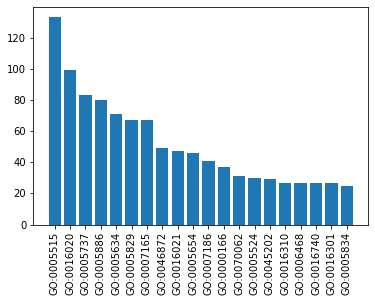

In [7]:
#Plot the top 20 most common GO terms
top_10_GO = results['go_id'].value_counts()[:20]
plt.bar(top_10_GO.index , top_10_GO.values)
plt.xticks(rotation='vertical')
plt.show()

Check the function of the most common GO terms [here](https://www.ebi.ac.uk/QuickGO/)

### [PantherDB](http://www.pantherdb.org/)

A similar analysis identify gene ontology (GO) terms can be performed. In order to do this we need to extract the entrezgene ID's and save them to a .txt file

In [13]:
entrezgene_id = list(results['entrezgene_id'].dropna().drop_duplicates())

In [14]:
with open('entrezgene_id.txt', 'w') as f:
    f.write('\n'.join(str(gene) for gene in entrezgene_id))

Input this file into [PantherDB](http://www.pantherdb.org/). 

Select Functional classification viewed in graphic charts bar chart

Compare to the plot above

Do the GO terms match up to that found in PantherDB, why or why not? 